In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb 
from sklearn.metrics import classification_report, accuracy_score 
import matplotlib.pyplot as plt 
import joblib 
import os 

def loadData(path):
    try:
       
        abs_path = os.path.abspath(path)
        data = pd.read_csv(abs_path)
        return data
    except FileNotFoundError:
        print(f"Error: File '{path}' not found.")
        return None
    except Exception as e:
        print(f"Error: Failed to load data from '{path}'.")
        print(f"Details: {str(e)}")
        return None


def displayData(data):
    if data is not None:
        print("First 5 rows of the dataset:")
        print(data.head())
        print("\nTotal number of rows and columns:")
        print("Rows:", data.shape[0])
        print("Columns:", data.shape[1])


relative_path = 'data/loan.csv'  


loadedData = loadData(relative_path)


displayData(loadedData)

First 5 rows of the dataset:
          loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3  LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4  LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   

              applicationDate  originated              originatedDate  \
0  2016-02-23T17:29:01.940000       False                         NaN   
1  2016-01-19T22:07:36.778000        True  2016-01-20T15:49:18.846000   
2  2016-08-01T13:51:14.709000       False                         NaN   
3  2015-08-06T23:58:08.880000       False                         NaN   
4  2016-06-05T22:31:34.304000       False                         NaN   

   nPaidOff  approved  isFunded             loanStatus  loanAmount  \
0       0.0     F

In [2]:

numerical_summary = loadedData.describe()

categorical_summary = loadedData.describe(include='object').dropna(axis=1)

print("Summary statistics for numerical features:")
print(numerical_summary)

print("\nSummary statistics for categorical features:")
print(categorical_summary)

Summary statistics for numerical features:
                 apr       nPaidOff       isFunded     loanAmount  \
count  573760.000000  577658.000000  577682.000000  575432.000000   
mean      553.080972       0.037887       0.067480     514.245084   
std       110.046159       0.333366       0.250852     320.939929   
min         0.000000       0.000000       0.000000       0.000000   
25%       490.000000       0.000000       0.000000     350.000000   
50%       590.000000       0.000000       0.000000     500.000000   
75%       601.000000       0.000000       0.000000     500.000000   
max       705.590000      21.000000       1.000000    5000.000000   

       originallyScheduledPaymentAmount       leadCost          hasCF  
count                     577682.000000  577682.000000  577682.000000  
mean                        1428.897209       7.854389       0.619187  
std                          925.009141      12.853451       0.485587  
min                         -816.710000       0

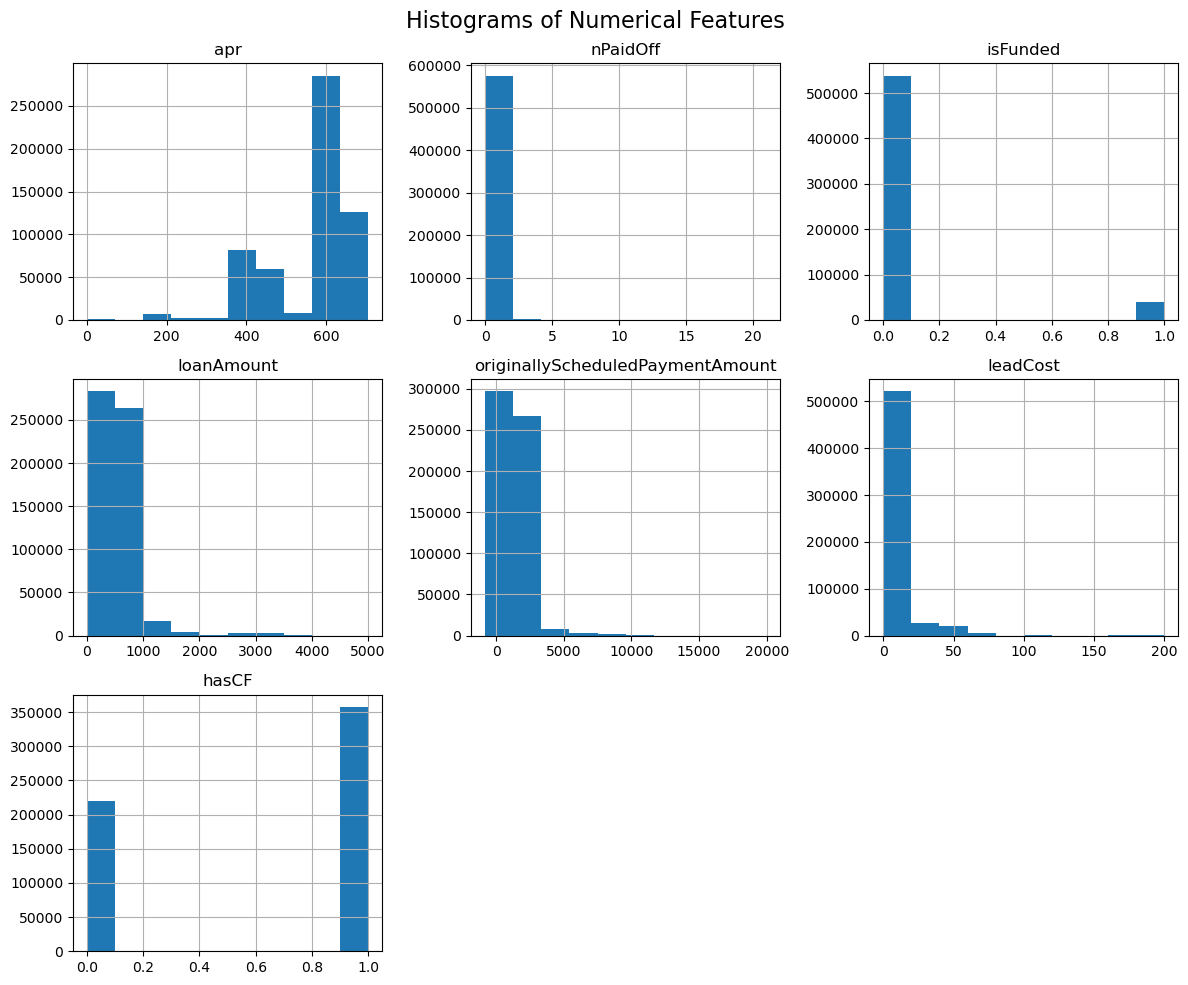

In [3]:


loadedData.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()


In [4]:

categorical_features = loadedData.select_dtypes(include=['object'])

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_features.columns):
    plt.subplot(3, 3, i+1)
    categorical_features[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:

def checkDuplicateData(data): 
        duplicated_ids = data[data.duplicated(subset=['loanId'])]['loanId'].unique()
        return duplicated_ids
duplicate_ids = checkDuplicateData(loadedData)

print("Duplicate loanId values found:", duplicate_ids)
# No duplicated data found

Duplicate loanId values found: [nan]


In [ ]:

def removenullValue(data):
    relevant_cols = ['loanAmount', 'apr', 'payFrequency', 'leadType', 'leadCost', 'fpStatus', 'hasCF', 'loanStatus']
    

    print("\nTotal rows before cleaning:", data.shape[0])
    print("Total columns before cleaning:", data.shape[1])
    
 
    data = data[relevant_cols].dropna()
    
    return data

cleanedData = removenullValue(loadedData)

print("\nTotal rows after removal:", cleanedData.shape[0])
print("Total columns after removal:", cleanedData.shape[1])


Total rows before cleaning: 577682
Total columns before cleaning: 19

Total rows after removal: 48193
Total columns after removal: 8


In [ ]:

def DataEncode_DataSplit(data):
    le = LabelEncoder()
  
    data['loanStatus'] = le.fit_transform(data['loanStatus'])
    loan_status_labels = dict(zip(le.classes_, le.transform(le.classes_)))
    
    encoded_labels = {'loanStatus': loan_status_labels}

    for col in ['payFrequency', 'leadType', 'fpStatus']:
        data[col] = le.fit_transform(data[col])
        encoded_labels[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    x = data.drop('loanStatus', axis=1)
    y = data['loanStatus']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test, encoded_labels

x_train, x_test, y_train, y_test, encoded_labels = DataEncode_DataSplit(cleanedData)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nEncoded labels:")
for col, labels in encoded_labels.items():
    print(f"{col}: {labels}")


Shape of x_train: (38554, 7)
Shape of x_test: (9639, 7)
Shape of y_train: (38554,)
Shape of y_test: (9639,)

Encoded labels:
loanStatus: {'CSR Voided New Loan': 0, 'Charged Off': 1, 'Charged Off Paid Off': 2, 'External Collection': 3, 'Internal Collection': 4, 'New Loan': 5, 'Paid Off Loan': 6, 'Pending Paid Off': 7, 'Rejected': 8, 'Returned Item': 9, 'Settled Bankruptcy': 10, 'Settlement Paid Off': 11, 'Settlement Pending Paid Off': 12, 'Withdrawn Application': 13}
payFrequency: {'B': 0, 'I': 1, 'M': 2, 'S': 3, 'W': 4}
leadType: {'bvMandatory': 0, 'california': 1, 'express': 2, 'instant-offer': 3, 'lead': 4, 'lionpay': 5, 'organic': 6, 'prescreen': 7, 'rc_returning': 8, 'repeat': 9}
fpStatus: {'Cancelled': 0, 'Checked': 1, 'No Payments': 2, 'Pending': 3, 'Rejected': 4, 'Returned': 5, 'Skipped': 6}


In [ ]:


def LightGBM_model(x_train, y_train, x_test, y_test):
  
    lgb_classifier = lgb.LGBMClassifier(num_leaves=200, learning_rate=0.1, n_estimators=5,
                                    min_child_samples=10, min_split_gain=0.05,
                                    min_child_weight=0.01, force_row_wise=True)
 
    lgb_classifier.fit(x_train, y_train)
   
    joblib.dump(lgb_classifier, 'models/LightGBM_model.pkl')
  
    y_pred = lgb_classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
   
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)

LightGBM_model(x_train, y_train, x_test, y_test)



[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 38554, number of used features: 7
[LightGBM] [Info] Start training from score -10.559815
[LightGBM] [Info] Start training from score -5.739534
[LightGBM] [Info] Start training from score -1.444005
[LightGBM] [Info] Start training from score -2.161631
[LightGBM] [Info] Start training from score -1.779642
[LightGBM] [Info] Start training from score -1.436232
[LightGBM] [Info] Start training from score -5.661975
[LightGBM] [Info] Start training from score -4.983866
[LightGBM] [Info] Start training from score -3.689762
[LightGBM] [Info] Start training from score -5.026426
[LightGBM] [Info] Start training from score -4.217694
[LightGBM] [Info] Start training from score -10.559815
[LightGBM] [Info] Start training from score -1.701020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
